# Data Analysis of the Seattle Airbnb data set

## Questions analysed in this analysis:
1. In which season do prices in Seattle climax?
2. Which areas of the city are most affected by the price spike?
3. Which attributes are the most important to predict prices?

In [1]:
# import the neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [2]:
# Download the csv.Files from https://www.kaggle.com/airbnb/seattle 
# and save it into the same folder you saved this file "Data Analysis.ipynb" into
# Then run this cell

calendar = pd.read_csv("calendar.csv")
listings = pd.read_csv("listings.csv")
reviews = pd.read_csv("reviews.csv")

# 1. In which season do prices in Seattle climax?

In [3]:
"""Functions for Cleaning Data"""

def correction (x):
    """
    Make string columns to floats -> e.g. "85.00$" into 85.00
    """
    if type(x) == str:
        
        x = x.replace(",","")
        
        x = x.replace("$","")
        
        x = x.replace("%", "")
        
        x = float(x)    
    return (x)

"""def correction_zipcode (x):
    
    Clean Zipcode '99\n98122'into '98122' 
    
    if x == '99\n98122':
        x = '98122'
        
    return x"""

def get_year(x):
    
    """
    INPUT: year as input
    OUTPUT: Return the difference between input year and 2016
    """
    if type(x) != float:
        x = x.split("-")[0]
    
    return 2016-float(x)


# Lambda function to fill missing values with the mean of the column
fill_mean = lambda col: col.fillna(col.mean())

# turn strings for true and false "t" and "f" into 1 and 0
t_F_handling = lambda x: 1 if x =="t" else 0

Wrangling and Cleaning the Data

In [4]:
# Creating column that contents the year and the month
calendar["date_year_month"]=calendar["date"].apply(lambda x: x[:-3])

# Join price & neighborhood column to the calendar DataFrame
calendar= pd.merge(left=calendar, 
                   right=listings[["id", "price", "neighbourhood_group_cleansed"]],
                   left_on="listing_id", 
                   right_on="id", 
                   how="left")

# Fill the missing values for the price column in the Calendar DataFrame withthe prices from the listings DataFrame
calendar["price_x"] = calendar["price_x"].fillna(calendar["price_y"])

# Clean the price column
calendar["price_x"] = calendar["price_x"].apply(lambda x: correction(x))

# Rename columns and drop uneccessary ones that are not needed for further analysis
calendar = calendar.rename(columns={"price_x": "price", "neighbourhood_group_cleansed": "area"}).drop(labels = "price_y", axis=1)

calendar.head()



,listing_id,date,available,price,date_year_month,id,area
0,241032,2016-01-04,t,85.0,2016-01,241032,Queen Anne
1,241032,2016-01-05,t,85.0,2016-01,241032,Queen Anne
2,241032,2016-01-06,f,85.0,2016-01,241032,Queen Anne
3,241032,2016-01-07,f,85.0,2016-01,241032,Queen Anne
4,241032,2016-01-08,f,85.0,2016-01,241032,Queen Anne


Analysing the Data

In [5]:
# Average price of all listings per month
season= calendar[["price", "date_year_month"]].groupby(by="date_year_month").mean().reset_index()

# Average price per month and area
season_area = calendar[["price", "date_year_month", "area"]].groupby(by=["area","date_year_month"]).mean().reset_index()

# Average price per area
average_price_area = calendar[["price", "area"]].groupby(by=["area"]).mean().reset_index()

# Average price of all listings over timespan of the data
average_price_overall = listings["price"].apply(lambda x: correction(x)).mean()

average_price_area.sort_values(by="price")

,area,price
5,Delridge,88.047997
10,Northgate,92.166712
8,Lake City,94.825843
13,Rainier Valley,95.748876
1,Beacon Hill,97.183237
15,University District,99.233550
14,Seward Park,109.277771
7,Interbay,115.956912
11,Other neighborhoods,126.192516
0,Ballard,127.077844


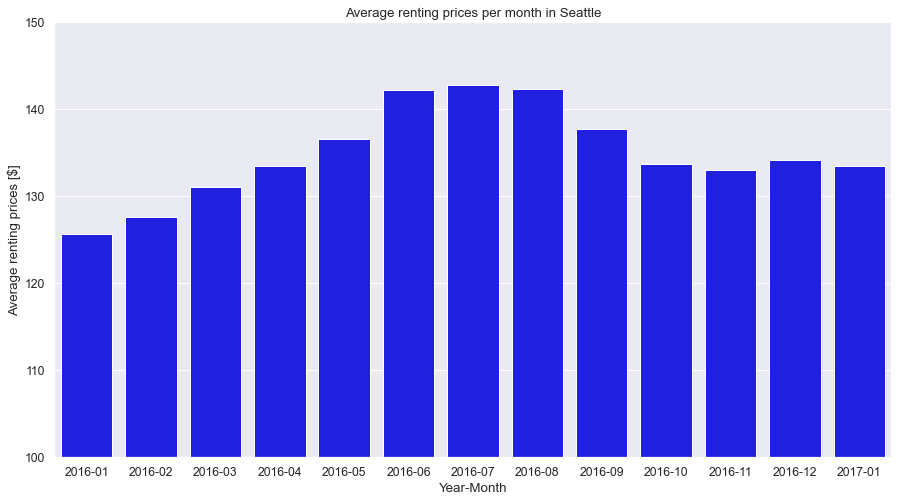

In [6]:
# Plot The average renting prices per month in Seatlle 
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.11)
plot= sns.barplot(x=season["date_year_month"], y=season["price"], color="blue")
plot.set(ylim=(100,150), title="Average renting prices per month in Seattle", xlabel="Year-Month", ylabel="Average renting prices [$]");


### FINDING: Prices spike in the summer months of June, July and August

# 2. Which areas of the city are most affected by the price spike?

In [7]:
# Average prices in summer months per area

area_mean_price_month = season_area[season_area["date_year_month"].isin(["2016-06", "2016-07", "2016-08"])][["area", "price"]].groupby(by="area").mean().reset_index().sort_values(by="price", ascending=False)
area_mean_price_month

,area,price
6,Downtown,198.464708
9,Magnolia,194.859246
12,Queen Anne,171.236336
16,West Seattle,153.797669
3,Cascade,146.488563
2,Capitol Hill,138.993815
4,Central Area,137.134093
0,Ballard,132.946597
11,Other neighborhoods,131.417925
7,Interbay,120.059694


In [8]:
# Comparison between Average price over summer months and average price of the zipcode over the whole timespan
area_mean_avg_price_month= pd.merge(left=area_mean_price_month, right=average_price_area, how="left", on="area")

area_mean_avg_price_month["effect"] = area_mean_avg_price_month["price_x"]/area_mean_avg_price_month["price_y"]


In [9]:
# Average price over the whole year campared with average price of the summer months June, July and August
area_mean_avg_price_month.sort_values(by="effect", ascending=False)

,area,price_x,price_y,effect
0,Downtown,198.464708,174.704714,1.136001
3,West Seattle,153.797669,146.522896,1.049649
7,Ballard,132.946597,127.077844,1.046182
8,Other neighborhoods,131.417925,126.192516,1.041408
15,Northgate,95.911622,92.166712,1.040632
14,Lake City,98.605526,94.825843,1.039859
2,Queen Anne,171.236336,164.708670,1.039632
13,Rainier Valley,99.513568,95.748876,1.039318
11,University District,102.770368,99.233550,1.035641
9,Interbay,120.059694,115.956912,1.035382


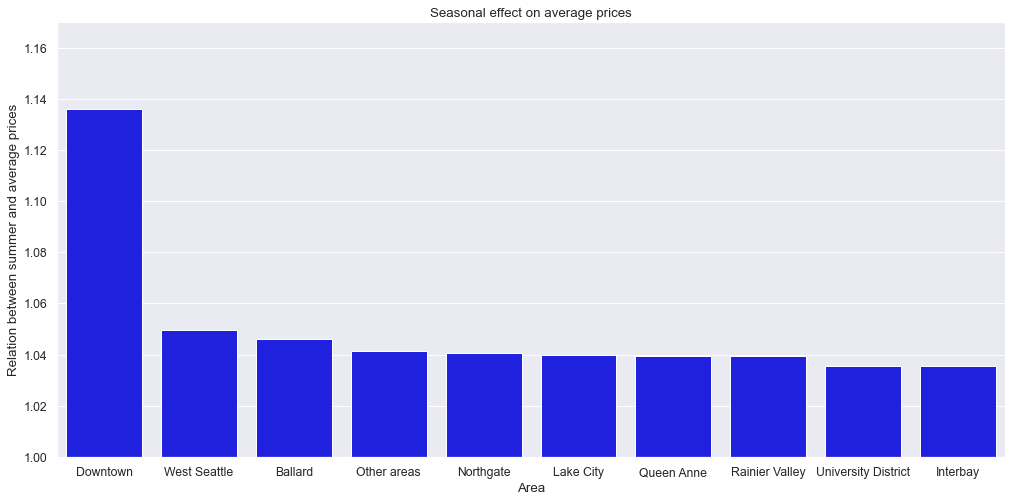

In [10]:
# Plot of the seasonal effect on prices in different areas
df=area_mean_avg_price_month.sort_values(by="effect", ascending=False)
df["area"] = df["area"].apply(lambda x: "Other areas" if x=="Other neighborhoods" else x)

x_plot =df["area"]
y_plot =df["effect"]

plt.figure(figsize=(17,8))
sns.set(font_scale = 1.11)
plot= sns.barplot(x=x_plot[:10], y=y_plot[:10], color="blue")
plot.set(ylim=(1,1.17), title="Seasonal effect on average prices", xlabel="Area", ylabel="Relation between summer and average prices");


## FINDING: Appartments in Downtown Seattle are 13,6% higher in price in the summer months of June, July and August compared to the average price over the whole year

In [11]:
# Average prices per month in Downtown Seattle
Downtown = calendar[["date_year_month", "price", "area"]][calendar["area"] == "Downtown"].groupby(by=["date_year_month", "area"]).mean().reset_index()
Downtown

,date_year_month,area,price
0,2016-01,Downtown,149.787871
1,2016-02,Downtown,152.370982
2,2016-03,Downtown,165.450822
3,2016-04,Downtown,170.263648
4,2016-05,Downtown,179.068716
5,2016-06,Downtown,199.197044
6,2016-07,Downtown,199.046379
7,2016-08,Downtown,197.150700
8,2016-09,Downtown,178.845535
9,2016-10,Downtown,167.880706


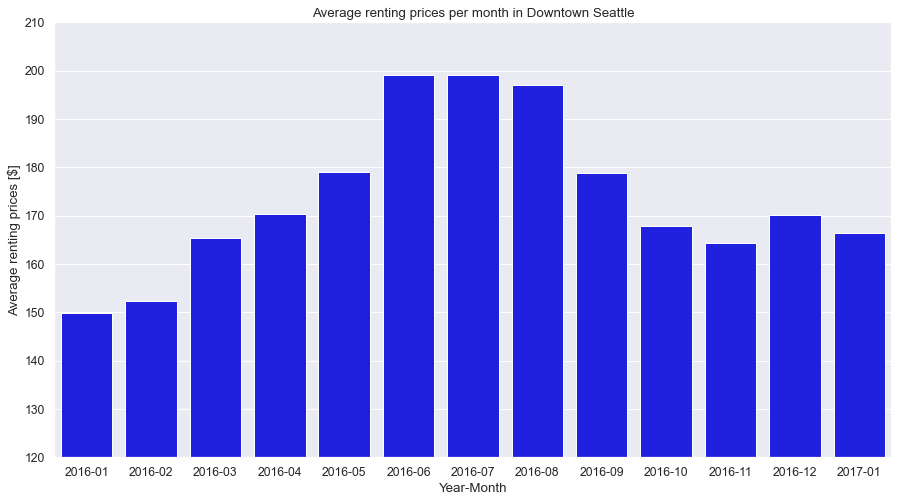

In [12]:
# Plot of average prices per month in Downtown Seattle
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.11)
plot= sns.barplot(x=Downtown["date_year_month"], y=Downtown["price"], color="blue")
plot.set(ylim=(120,210), title="Average renting prices per month in Downtown Seattle", xlabel="Year-Month", ylabel="Average renting prices [$]");


# 3. Which attributes are the most important to predict prices?

In [13]:
# Columns to be included in the regression
columns= [
    "price","host_since_streamlined","host_response_rate",
    "host_is_superhost", "host_listings_count","host_identity_verified",
    "area","property_type", "accommodates",
    "bathrooms","bedrooms","beds",
    "bed_type","number_of_reviews", "review_scores_rating",
    "instant_bookable","cancellation_policy", "reviews_per_month"
]

In [14]:
"""
Cleaning Data
"""

# Run this code just once, else you will have some columns with just zeros
# Turning t into 1 and f into 0 for True and False
listings["host_has_profile_pic"]=listings["host_has_profile_pic"].apply(t_F_handling)
listings["host_is_superhost"] = listings["host_is_superhost"].apply(t_F_handling)
listings["host_identity_verified"] = listings["host_identity_verified"].apply(t_F_handling)
listings["instant_bookable"] = listings["instant_bookable"].apply(t_F_handling)

# Correction of the price, turn strings into the correct floats
listings["price"] = listings["price"].apply(lambda x :correction(x))

# Same with the host response rate, that is saved as a string in the origin Dataframe
listings["host_response_rate"]= listings["host_response_rate"].apply(lambda x: correction(x))

# Fill NAN with Mean for numeric variables
listings[["host_response_rate"]] = listings[["host_response_rate"]].apply(fill_mean, axis=0)
listings[["bathrooms"]] = listings[["bathrooms"]].apply(fill_mean, axis=0)
listings[["bedrooms"]] = listings[["bedrooms"]].apply(fill_mean, axis=0)
listings[["beds"]] = listings[["beds"]].apply(fill_mean, axis=0)
listings[["review_scores_rating"]] = listings[["review_scores_rating"]].apply(fill_mean, axis=0)
listings[["reviews_per_month"]] = listings[["reviews_per_month"]].apply(fill_mean, axis=0)

# Make Years out of the date for the variable "host since"
listings["host_since_streamlined"] = listings["host_since"].apply(lambda x:get_year(x))

# rename area_group_cleansed into area, because its shorter
listings = listings.rename(columns={"neighbourhood_group_cleansed":"area"})

# drop na's from columns where just very few values in rows are missing 
listings.dropna(axis=0, subset=["host_since_streamlined", "host_listings_count", "host_has_profile_pic", "property_type"], inplace=True)

# categorial variables to be considered in the regression
cat_var = ["area", "property_type", "room_type", "bed_type","cancellation_policy"]

# cleaned dataset
listings[columns].head()

,price,host_since_streamlined,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,area,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,85.0,5.0,96.000000,0,3.0,1,Queen Anne,Apartment,4,1.0,1.0,1.0,Real Bed,207,95.000000,0,moderate,4.070000
1,150.0,3.0,98.000000,1,6.0,1,Queen Anne,Apartment,4,1.0,1.0,1.0,Real Bed,43,96.000000,0,strict,1.480000
2,975.0,2.0,67.000000,0,2.0,1,Queen Anne,House,11,4.5,5.0,7.0,Real Bed,20,97.000000,0,strict,1.150000
3,100.0,3.0,94.886798,0,1.0,1,Queen Anne,Apartment,3,1.0,0.0,2.0,Real Bed,0,94.539262,0,flexible,2.078919
4,450.0,5.0,100.000000,0,2.0,1,Queen Anne,House,6,2.0,3.0,3.0,Real Bed,38,92.000000,0,strict,0.890000


In [15]:
"""
Turning categorial variables into dummies
"""

def prepare_df(df, consider_na):
    
    """
    INPUT 
        df [DataFrame]: The dataframe including the catecorial variables that are to be turned into dummies
        consider_na [bool]: Wheather or not Nan values should get an own column of dummies
    OUTPUT:
        The Dataframe df with the categorial columns turned into dummies
        """
    df= df.dropna(subset=["price"], axis=0)
    cat_vars = df.select_dtypes(include=["object"]).copy().columns
    
    for i in cat_vars:
        df = pd.concat([df.drop(labels=i, axis=1), pd.get_dummies(data=df[i], dummy_na=consider_na, prefix=i, prefix_sep="_", drop_first=True)],axis=1)
        
    return df

In [16]:
# Clean the listing dataset (turn categorial vars into dummies)
clean_listings= prepare_df(df=listings[columns], consider_na=False)

# columns with more than .5% specifications considered in regression --> 
# Dummy variables with less than 0.5% 1s not included in regression
columns_to_consider=clean_listings.columns[clean_listings.describe().loc["mean"] >0.005]
clean_listings= clean_listings[columns_to_consider]

In [17]:
# Define X and y
X=clean_listings.drop("price", axis=1)
y=clean_listings["price"]

In [18]:
# Split into train, test and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create and fit
lm_model= LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
  
# Predict 
y_pred_test = lm_model.predict(X_test)
y_pred_train = lm_model.predict(X_train)

# Calculate r2 for train and test samples
r2_test = r2_score(y_test,y_pred_test)
r2_train = r2_score(y_train,y_pred_train)

In [19]:
# R-squared of the test data set
r2_test

0.5475810682503601

In [20]:
# R-squares of the train dataset
r2_train

0.5440804864198202

In [21]:
# Coefficients of the Regression
Coeff= pd.DataFrame(data=lm_model.coef_, index=X_train.columns.to_list(), columns=["Coefficients"]).reset_index()

In [22]:
# Show the coefficients that have the most impact on high prices 

Coeff= Coeff.sort_values(by=['Coefficients'], ascending=False)
Coeff= Coeff.rename(columns={"index":"Variables"})
Coeff.head(12)

,Variables,Coefficients
18,area_Downtown,34.829551
20,area_Magnolia,31.531152
32,property_type_Loft,30.906852
7,bedrooms,27.520637
6,bathrooms,27.411965
23,area_Queen Anne,26.508005
15,area_Cascade,25.843812
37,bed_type_Real Bed,25.804004
29,property_type_Cabin,18.792226
5,accommodates,15.506518


In [23]:
# Show the coefficients with the most negative impact on prices
Coeff.sort_values(by="Coefficients", ascending=True).head(12)

,Variables,Coefficients
21,area_Northgate,-32.804185
17,area_Delridge,-31.688218
24,area_Rainier Valley,-27.141980
13,area_Beacon Hill,-19.257938
25,area_Seward Park,-18.071088
19,area_Lake City,-14.062221
26,area_University District,-13.592005
22,area_Other neighborhoods,-8.046481
16,area_Central Area,-7.846430
31,property_type_House,-6.716084
